<a href="https://colab.research.google.com/github/Dushani-Ranasinghe/Pediatric-Bone-Age-Prediction/blob/main/BAA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Resize images to 224, 224

In [ ]:
import os
import pandas as pd
from PIL import Image

# Define the target size for VGG16 input
TARGET_SIZE = (224, 224)

# Directories and CSV paths
segmented_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Segment/Training'
segmented_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Segment/Validation'
training_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/training.csv'
validation_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/validation.csv'

# Directories to save resized images
resized_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Segment/Resized/Training'
resized_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Segment/Resized/Validation'

# Create directories if they do not exist
os.makedirs(resized_training_dir, exist_ok=True)
os.makedirs(resized_val_dir, exist_ok=True)

def resize_image_with_aspect_ratio(image_path, target_size=TARGET_SIZE):
    with Image.open(image_path) as img:
        # Calculate the new size maintaining the aspect ratio
        img.thumbnail(target_size, Image.ANTIALIAS)

        # Create a new image with the target size and black padding
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        offset = ((target_size[0] - img.width) // 2, (target_size[1] - img.height) // 2)
        new_img.paste(img, offset)

        return new_img

def process_images(directory, csv_path, output_directory):
    df = pd.read_csv(csv_path)
    processed_images = []
    for index, row in df.iterrows():
        image_id = row['id']
        image_path = os.path.join(directory, f"{image_id}.png")
        if os.path.exists(image_path):
            resized_image = resize_image_with_aspect_ratio(image_path)
            # Save the resized image to the new directory
            resized_image_path = os.path.join(output_directory, f"{image_id}.png")
            resized_image.save(resized_image_path)
            processed_images.append(resized_image_path)
    return processed_images

# Process training and validation images
training_images = process_images(segmented_training_dir, training_csv_path, resized_training_dir)
validation_images = process_images(segmented_val_dir, validation_csv_path, resized_val_dir)

print(f"Processed and saved {len(training_images)} training images.")
print(f"Processed and saved {len(validation_images)} validation images.")


<ipython-input-2-a79d1ea6a135>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)
<ipython-input-2-a79d1ea6a135>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)


Processed and saved 1133 training images.
Processed and saved 140 validation images.


## Data augmentation

In [ ]:
!pip install tensorflow opencv-python-headless pandas numpy matplotlib

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 3977.4373 - mae: 31.0457 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1039s 29s/step - loss: 3977.4373 - mae: 31.0457 - val_loss: 213.8960 - val_mae: 11.8832 - lr: 0.0010
Epoch 2/30
36/36 [==============================] - 1035s 29s/step - loss: 455.9202 - mae: 17.0578 - val_loss: 179.3186 - val_mae: 10.4991 - lr: 0.0010
Epoch 3/30
36/36 [==============================] - 1026s 29s/step - loss: 424.0126 - mae: 16.4569 - val_loss: 172.2455 - val_mae: 10.4237 - lr: 0.0010
Epoch 4/30
36/36 [==============================] - 1031s 29s/step - loss: 363.8234 - mae: 15.2219 - val_loss: 226.6202 - val_mae: 12.2016 - lr: 0.0010
Epoch 5/30
36/36 [==============================] - 1022s 29s/step - loss: 341.1684 - mae: 14.7102 - val_loss: 176.5676 - val_mae: 10.7565 - lr: 0.0010
Epoch 6/30
36/36 [==============================] - 1023s 29s/step - loss: 298.0867 - mae: 13.6932 - val_loss: 212.4650 - val_mae: 11.6153 - lr: 0.0010
Epoch 7/30
36/36 [==============================] - 1023s 29s/step - loss: 289.9188 - mae: 13.7056

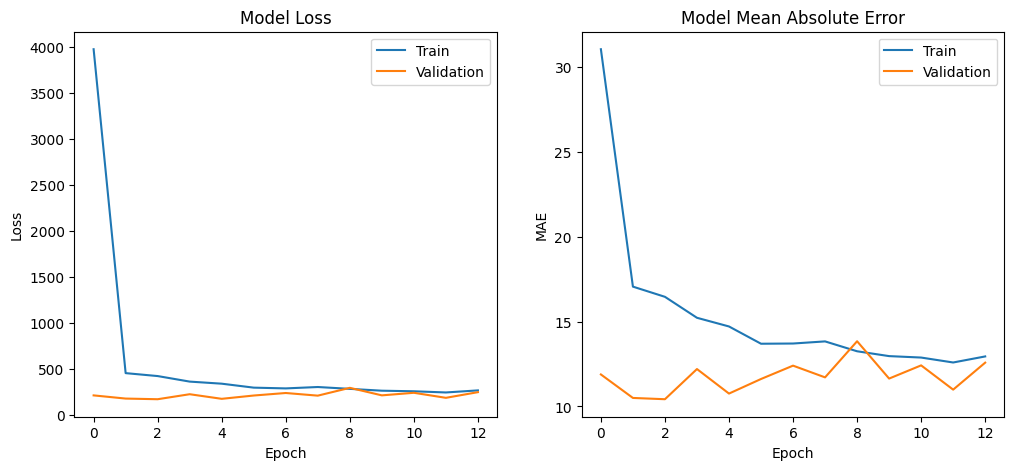

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths to data and CSV files
resized_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Training'
resized_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Validation'
training_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/training.csv'
validation_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/validation.csv'

# Load the CSV data
train_df = pd.read_csv(training_csv_path)
val_df = pd.read_csv(validation_csv_path)

# Convert 'id' column to string
train_df['id'] = train_df['id'].astype(str)
val_df['id'] = val_df['id'].astype(str)

# Function to load images
def load_images_from_df(df, image_dir):
    images = []
    ages = []
    genders = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['id'] + '.png')
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            ages.append(row['boneage'])
            genders.append(row['male'])
    return np.array(images), np.array(ages), np.array(genders)

# Load training and validation images
X_train, y_train, genders_train = load_images_from_df(train_df, resized_training_dir)
X_val, y_val, genders_val = load_images_from_df(val_df, resized_val_dir)

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# VGG16 base model
input_shape = X_train.shape[1:]
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers except the last 4 layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

# Add custom layers
x = vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Add gender input
gender_input = Input(shape=(1,), name='gender_input')
gender_dense = Dense(16, activation='relu')(gender_input)

# Combine VGG and gender inputs
combined = concatenate([x, gender_dense])
age_output = Dense(1, name='age_output')(combined)

model = Model(inputs=[vgg.input, gender_input], outputs=age_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Create combined generator
def combined_generator(image_gen, gender_input):
    while True:
        batch_img, batch_age = image_gen.next()
        gender_data = gender_input[:len(batch_img)]
        yield [batch_img, gender_data], batch_age

# Train the model
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Plotting the training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
import os

# List files in the directory to check if the model file exists
model_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/'
print(os.listdir(model_dir))


['Dataset', 'VGG16_bone_age_model.h5']


Epoch 14/30
36/36 [==============================] - 1023s 28s/step - loss: 373.1584 - mae: 15.4977 - val_loss: 165.8050 - val_mae: 10.4062 - lr: 2.0000e-04
Epoch 15/30
36/36 [==============================] - 1031s 29s/step - loss: 303.0024 - mae: 14.1076 - val_loss: 195.3159 - val_mae: 11.1956 - lr: 2.0000e-04
Epoch 16/30
36/36 [==============================] - 982s 27s/step - loss: 302.5998 - mae: 14.0091 - val_loss: 243.3130 - val_mae: 12.6247 - lr: 2.0000e-04
Epoch 17/30
36/36 [==============================] - 970s 27s/step - loss: 279.8299 - mae: 13.3831 - val_loss: 175.3449 - val_mae: 10.7114 - lr: 2.0000e-04
Epoch 18/30
36/36 [==============================] - 1020s 28s/step - loss: 288.9337 - mae: 13.3477 - val_loss: 308.8017 - val_mae: 14.2349 - lr: 2.0000e-04
Epoch 19/30
36/36 [==============================] - 1021s 28s/step - loss: 286.0450 - mae: 13.5110 - val_loss: 190.6655 - val_mae: 11.0729 - lr: 2.0000e-04
Epoch 20/30
36/36 [==============================] - 970s 27

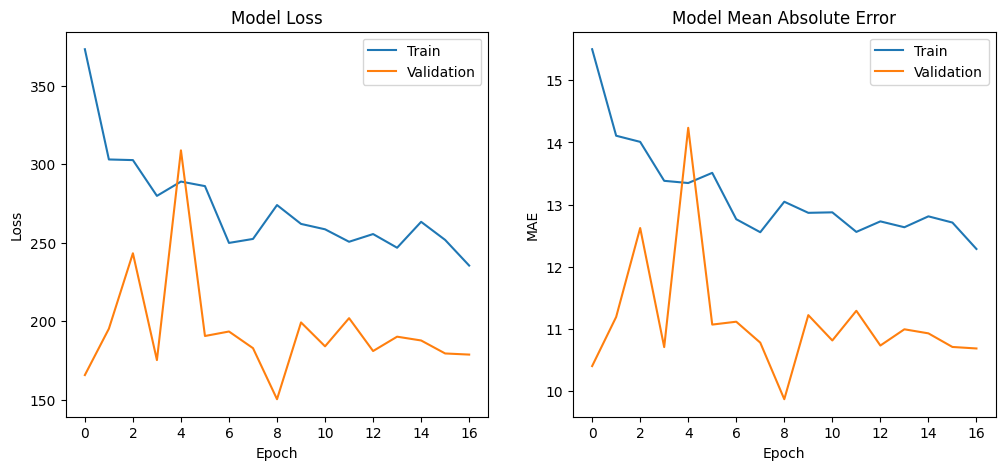

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the combined generator function again if needed
def combined_generator(image_gen, gender_input):
    while True:
        batch_img, batch_age = image_gen.next()
        gender_data = gender_input[:len(batch_img)]
        yield [batch_img, gender_data], batch_age

# Path to the best model
best_model_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model.h5'

# Load the best model
model = load_model(best_model_path)

# Re-compile the model if necessary
model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])

# Model Checkpoint
checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model further
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    initial_epoch=13,  # Continue from the last epoch
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Plotting the training history
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
import tensorflow as tf

# Correct the model file path
model_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model.h5'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

# resize test set

In [ ]:
import os
from PIL import Image

# Define the target size for VGG16 input
TARGET_SIZE = (224, 224)

# Directory paths
segmented_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/segmented'
resized_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/resized'

# Create resized directory if it doesn't exist
os.makedirs(resized_dir, exist_ok=True)

def resize_image_with_aspect_ratio(image_path, target_size=TARGET_SIZE):
    with Image.open(image_path) as img:
        # Calculate the new size maintaining the aspect ratio
        img.thumbnail(target_size, Image.ANTIALIAS)

        # Create a new image with the target size and black padding
        new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black background
        offset = ((target_size[0] - img.width) // 2, (target_size[1] - img.height) // 2)
        new_img.paste(img, offset)

        return new_img

def process_images(directory, output_directory):
    files = os.listdir(directory)
    processed_images = []
    for i, file in enumerate(files):
        image_path = os.path.join(directory, file)
        if os.path.exists(image_path):
            resized_image = resize_image_with_aspect_ratio(image_path)
            # Save the resized image to the new directory
            resized_image_path = os.path.join(output_directory, file)
            resized_image.save(resized_image_path)
            processed_images.append(resized_image_path)

            # Display the first 10 resized images
            if i < 10:
                resized_image.show()
    return processed_images

# Resize the segmented images
processed_images = process_images(segmented_dir, resized_dir)

<ipython-input-2-dbc9a79a1d31>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)
<ipython-input-2-dbc9a79a1d31>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)
<ipython-input-2-dbc9a79a1d31>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)
<ipython-input-2-dbc9a79a1d31>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail(target_size, Image.ANTIALIAS)
<ipython-input-2-dbc9a79a1d31>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or

# Evaluation

5/5 [==============================] - 1s 126ms/step
Mean Absolute Error (MAE): 9.20
Mean Squared Error (MSE): 131.21
Root Mean Squared Error (RMSE): 11.45
R-squared (R²): 0.59
Accuracy (within ±2 years): 14.08%


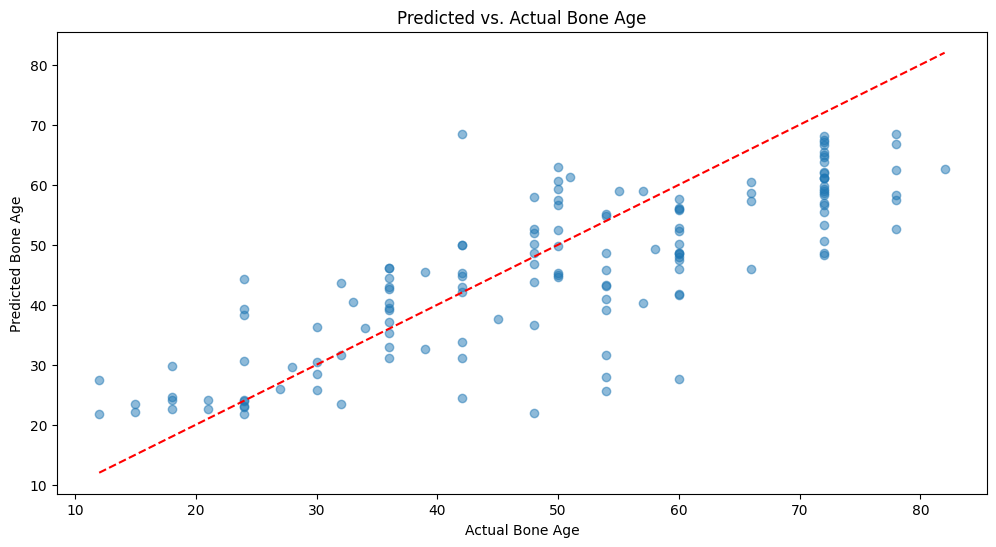

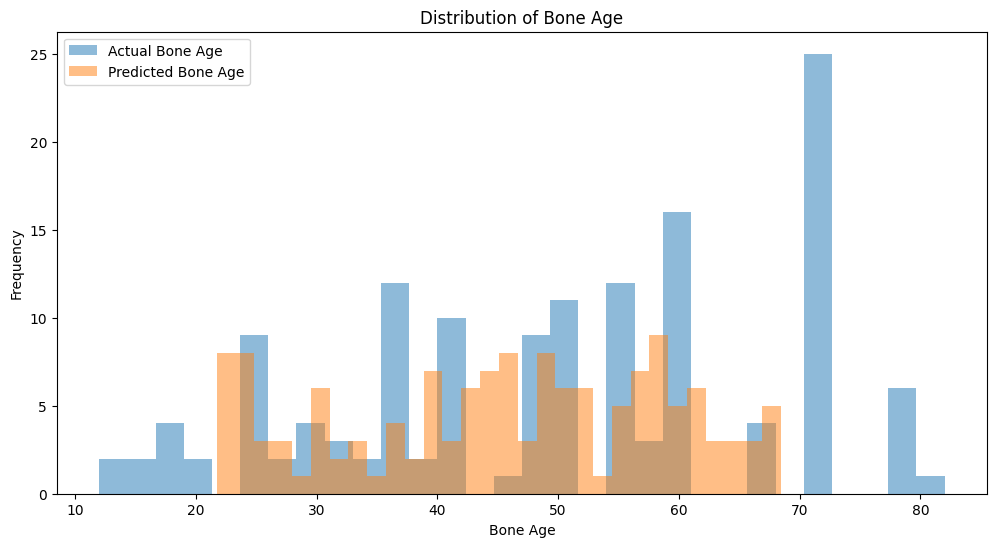

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the trained model
model_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model.h5'
model = load_model(model_path)

# Load the CSV file
test_csv = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/test.csv'
test_df = pd.read_csv(test_csv)

# Directory containing resized images
resized_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/resized'

# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Prepare test images and gender information
test_images = []
test_genders = []
test_boneages = []

for index, row in test_df.iterrows():
    img_path = os.path.join(resized_dir, str(row['id']) + '.png')  # Convert id to string
    test_images.append(load_and_preprocess_image(img_path))
    test_genders.append(1 if row['male'] else 0)  # Convert boolean to numeric (1 for male, 0 for female)
    test_boneages.append(row['boneage'])

# Stack images and convert lists to numpy arrays
test_images = np.vstack(test_images)
test_genders = np.array(test_genders).reshape(-1, 1)  # Ensure gender data is in the correct shape
test_boneages = np.array(test_boneages)

# Prepare the inputs for the model
test_images_with_gender = [test_images, test_genders]

# Predict bone age using the model
predicted_boneages = model.predict(test_images_with_gender)

# Calculate performance metrics
mae = np.mean(np.abs(predicted_boneages.flatten() - test_boneages))
mse = mean_squared_error(test_boneages, predicted_boneages)
rmse = np.sqrt(mse)
r2 = r2_score(test_boneages, predicted_boneages)

# Define accuracy threshold
accuracy_threshold = 2  # Adjust as needed (e.g., ±2 years)

# Calculate accuracy
accuracy = np.mean(np.abs(predicted_boneages.flatten() - test_boneages) <= accuracy_threshold) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R²): {r2:.2f}')
print(f'Accuracy (within ±{accuracy_threshold} years): {accuracy:.2f}%')

# Plot predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.scatter(test_boneages, predicted_boneages, alpha=0.5)
plt.plot([min(test_boneages), max(test_boneages)], [min(test_boneages), max(test_boneages)], 'r--')
plt.xlabel('Actual Bone Age')
plt.ylabel('Predicted Bone Age')
plt.title('Predicted vs. Actual Bone Age')
plt.show()

# Plot the distribution of predicted vs actual bone ages
plt.figure(figsize=(12, 6))
plt.hist(test_boneages, bins=30, alpha=0.5, label='Actual Bone Age')
plt.hist(predicted_boneages, bins=30, alpha=0.5, label='Predicted Bone Age')
plt.xlabel('Bone Age')
plt.ylabel('Frequency')
plt.title('Distribution of Bone Age')
plt.legend()
plt.show()


# Hyper parameter tuning

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    input_shape = X_train.shape[1:]
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers except the last 4 layers
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    # Add custom layers
    x = vgg.output
    x = Flatten()(x)
    x = Dense(hp.Int('units1', min_value=128, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout1', min_value=0.3, max_value=0.7, step=0.1))(x)
    x = Dense(hp.Int('units2', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout2', min_value=0.3, max_value=0.7, step=0.1))(x)

    # Add gender input
    gender_input = Input(shape=(1,), name='gender_input')
    gender_dense = Dense(hp.Int('gender_units1', min_value=8, max_value=32, step=8), activation='relu')(gender_input)
    gender_dense = Dense(hp.Int('gender_units2', min_value=4, max_value=16, step=4), activation='relu')(gender_dense)

    # Combine VGG and gender inputs
    combined = concatenate([x, gender_dense])
    age_output = Dense(1, name='age_output')(combined)

    model = Model(inputs=[vgg.input, gender_input], outputs=age_output)

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mse',
                  metrics=['mae'])

    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='bone_age_prediction'
)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def combined_generator(image_gen, gender_input):
    while True:
        batch_img, batch_age = image_gen.next()
        gender_data = gender_input[:len(batch_img)]
        yield [batch_img, gender_data], batch_age

tuner.search(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    epochs=50,
    callbacks=[early_stop]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    epochs=50,
    callbacks=[early_stop]
)

# Save the final model
model.save('/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model_tuned.h5')

# Plotting the training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

NameError: name 'EarlyStopping' is not defined

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the trained model
model_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model_tuned.h5'
model = load_model(model_path)

# Load the CSV file
test_csv = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/test.csv'
test_df = pd.read_csv(test_csv)

# Directory containing resized images
resized_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/resized'

# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Prepare test images and gender information
test_images = []
test_genders = []
test_boneages = []

for index, row in test_df.iterrows():
    img_path = os.path.join(resized_dir, str(row['id']) + '.png')  # Convert id to string
    test_images.append(load_and_preprocess_image(img_path))
    test_genders.append(1 if row['male'] else 0)  # Convert boolean to numeric (1 for male, 0 for female)
    test_boneages.append(row['boneage'])

# Stack images and convert lists to numpy arrays
test_images = np.vstack(test_images)
test_genders = np.array(test_genders).reshape(-1, 1)  # Ensure gender data is in the correct shape
test_boneages = np.array(test_boneages)

# Prepare the inputs for the model
test_images_with_gender = [test_images, test_genders]

# Predict bone age using the model
predicted_boneages = model.predict(test_images_with_gender)

# Calculate performance metrics
mae = np.mean(np.abs(predicted_boneages.flatten() - test_boneages))
mse = mean_squared_error(test_boneages, predicted_boneages)
rmse = np.sqrt(mse)
r2 = r2_score(test_boneages, predicted_boneages)

# Define accuracy threshold
accuracy_threshold = 2  # Adjust as needed (e.g., ±2 years)

# Calculate accuracy
accuracy = np.mean(np.abs(predicted_boneages.flatten() - test_boneages) <= accuracy_threshold) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R²): {r2:.2f}')
print(f'Accuracy (within ±{accuracy_threshold} years): {accuracy:.2f}%')

# Plot predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.scatter(test_boneages, predicted_boneages, alpha=0.5)
plt.plot([min(test_boneages), max(test_boneages)], [min(test_boneages), max(test_boneages)], 'r--')
plt.xlabel('Actual Bone Age')
plt.ylabel('Predicted Bone Age')
plt.title('Predicted vs. Actual Bone Age')
plt.show()

# Plot the distribution of predicted vs actual bone ages
plt.figure(figsize=(12, 6))
plt.hist(test_boneages, bins=30, alpha=0.5, label='Actual Bone Age')
plt.hist(predicted_boneages, bins=30, alpha=0.5, label='Predicted Bone Age')
plt.xlabel('Bone Age')
plt.ylabel('Frequency')
plt.title('Distribution of Bone Age')
plt.legend()
plt.show()


OSError: No file or directory found at /content/drive/MyDrive/FYP - Nexero/BAA model/VGG16_bone_age_model_tuned.h5

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 3069.9309 - mae: 31.3212

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 28s 600ms/step - loss: 3069.9309 - mae: 31.3212 - val_loss: 240.2943 - val_mae: 12.5951 - lr: 0.0010
Epoch 2/30
36/36 [==============================] - 17s 473ms/step - loss: 433.3916 - mae: 16.5481 - val_loss: 233.3714 - val_mae: 12.4089 - lr: 0.0010
Epoch 3/30
36/36 [==============================] - 19s 548ms/step - loss: 387.5441 - mae: 16.0591 - val_loss: 210.0962 - val_mae: 11.6916 - lr: 0.0010
Epoch 4/30
36/36 [==============================] - 14s 384ms/step - loss: 349.9441 - mae: 15.1921 - val_loss: 243.4110 - val_mae: 12.7050 - lr: 0.0010
Epoch 5/30
36/36 [==============================] - 21s 601ms/step - loss: 303.6654 - mae: 14.0325 - val_loss: 146.2083 - val_mae: 9.5450 - lr: 0.0010
Epoch 6/30
36/36 [==============================] - 12s 341ms/step - loss: 301.7796 - mae: 13.9168 - val_loss: 226.2243 - val_mae: 12.1131 - lr: 0.0010
Epoch 7/30
36/36 [==============================] - 14s 402ms/step - loss: 304.0596 - mae: 14.0479 

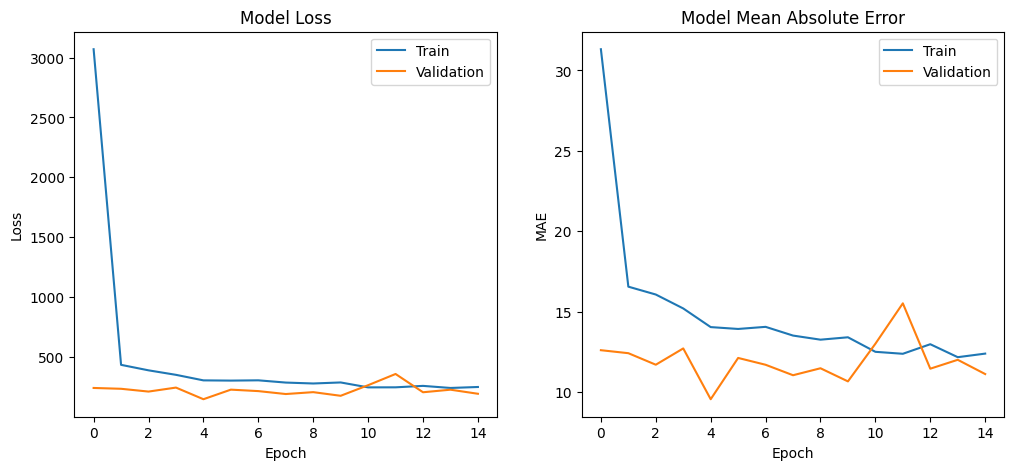

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths to data and CSV files
resized_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Training'
resized_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Validation'
training_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/training.csv'
validation_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/validation.csv'

# Load the CSV data
train_df = pd.read_csv(training_csv_path)
val_df = pd.read_csv(validation_csv_path)

# Convert 'id' column to string
train_df['id'] = train_df['id'].astype(str)
val_df['id'] = val_df['id'].astype(str)

# Function to load images
def load_images_from_df(df, image_dir):
    images = []
    ages = []
    genders = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['id'] + '.png')
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # Resize images to match input shape
            images.append(img)
            ages.append(row['boneage'])
            genders.append(row['male'])
    return np.array(images), np.array(ages), np.array(genders)

# Load training and validation images
X_train, y_train, genders_train = load_images_from_df(train_df, resized_training_dir)
X_val, y_val, genders_val = load_images_from_df(val_df, resized_val_dir)

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# VGG16 base model
input_shape = X_train.shape[1:]
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers except the last 4 layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

# Add custom layers
x = vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Add gender input
gender_input = Input(shape=(1,), name='gender_input')
gender_dense = Dense(16, activation='relu')(gender_input)

# Combine VGG and gender inputs
combined = concatenate([x, gender_dense])
age_output = Dense(1, name='age_output')(combined)

model = Model(inputs=[vgg.input, gender_input], outputs=age_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP - Nexero/BAA model/new/VGG16_bone_age_model.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Create combined generator
def combined_generator(image_gen, gender_data):
    while True:
        batch_img, batch_age = image_gen.next()
        batch_gender = gender_data[:len(batch_img)]
        yield [batch_img, batch_gender], batch_age

# Train the model
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val, genders_val], y_val),
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Evaluate the model
test_images, test_ages, test_genders = load_images_from_df(val_df, resized_val_dir)
test_images = test_images / 255.0  # Normalize test images

predicted_ages = model.predict([test_images, test_genders])
predicted_ages = predicted_ages.flatten()  # Flatten the predictions for evaluation

# Calculate performance metrics
mae = mean_absolute_error(test_ages, predicted_ages)
mse = mean_squared_error(test_ages, predicted_ages)
rmse = np.sqrt(mse)
r2 = r2_score(test_ages, predicted_ages)

# Calculate accuracy within ±2 years
accuracy_within_2_years = np.mean(np.abs(test_ages - predicted_ages) <= 2) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Accuracy (within ±2 years): {accuracy_within_2_years:.2f}%")

# Plotting the training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 2784.9260 - mae: 49.5557

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 37s 665ms/step - loss: 2784.9260 - mae: 49.5557 - val_loss: 2961.6375 - val_mae: 51.3142 - lr: 0.0010
Epoch 2/30
36/36 [==============================] - 25s 700ms/step - loss: 2716.5078 - mae: 48.8743 - val_loss: 2758.4792 - val_mae: 49.3083 - lr: 0.0010
Epoch 3/30
36/36 [==============================] - 27s 761ms/step - loss: 2621.0300 - mae: 47.8866 - val_loss: 2568.7705 - val_mae: 47.3775 - lr: 0.0010
Epoch 4/30
36/36 [==============================] - 14s 411ms/step - loss: 2465.0947 - mae: 46.1812 - val_loss: 2135.8181 - val_mae: 42.6306 - lr: 0.0010
Epoch 5/30
36/36 [==============================] - 19s 533ms/step - loss: 2249.1001 - mae: 43.7263 - val_loss: 1810.3561 - val_mae: 38.7374 - lr: 0.0010
Epoch 6/30
36/36 [==============================] - 23s 651ms/step - loss: 1955.6099 - mae: 40.1999 - val_loss: 1502.7557 - val_mae: 34.8001 - lr: 0.0010
Epoch 7/30
36/36 [==============================] - 16s 450ms/step - loss: 1586.1185 - 

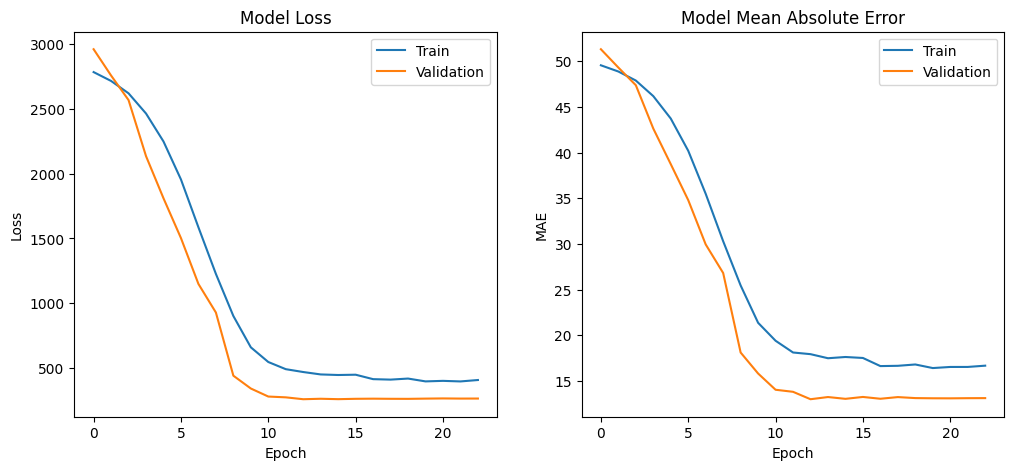

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths to data and CSV files
resized_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Training'
resized_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Validation'
training_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/training.csv'
validation_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/validation.csv'

# Load the CSV data
train_df = pd.read_csv(training_csv_path)
val_df = pd.read_csv(validation_csv_path)

# Convert 'id' column to string
train_df['id'] = train_df['id'].astype(str)
val_df['id'] = val_df['id'].astype(str)

# Function to load images
def load_images_from_df(df, image_dir):
    images = []
    ages = []
    genders = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['id'] + '.png')
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            ages.append(row['boneage'])
            genders.append(row['male'])
    return np.array(images), np.array(ages), np.array(genders)

# Load training and validation images
X_train, y_train, genders_train = load_images_from_df(train_df, resized_training_dir)
X_val, y_val, genders_val = load_images_from_df(val_df, resized_val_dir)

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# EfficientNetB0 base model
input_shape = X_train.shape[1:]
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers except the last 20 layers
for layer in efficientnet.layers[:-20]:
    layer.trainable = False

# Add custom layers
x = efficientnet.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add gender input
gender_input = Input(shape=(1,), name='gender_input')
gender_dense = Dense(32, activation='relu')(gender_input)
gender_dense = Dense(16, activation='relu')(gender_dense)

# Combine EfficientNet and gender inputs
combined = concatenate([x, gender_dense])
age_output = Dense(1, name='age_output')(combined)

model = Model(inputs=[efficientnet.input, gender_input], outputs=age_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP - Nexero/BAA model/EfficientNet_bone_age_model.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Create combined generator
def combined_generator(image_gen, gender_input):
    while True:
        batch_img, batch_age = image_gen.next()
        gender_data = gender_input[:len(batch_img)]
        yield [batch_img, gender_data], batch_age

# Train the model
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Plotting the training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


5/5 [==============================] - 3s 327ms/step
Mean Absolute Error (MAE): 12.86
Mean Squared Error (MSE): 250.90
Root Mean Squared Error (RMSE): 15.84
R-squared (R²): 0.22
Accuracy (within ±2 years): 14.08%


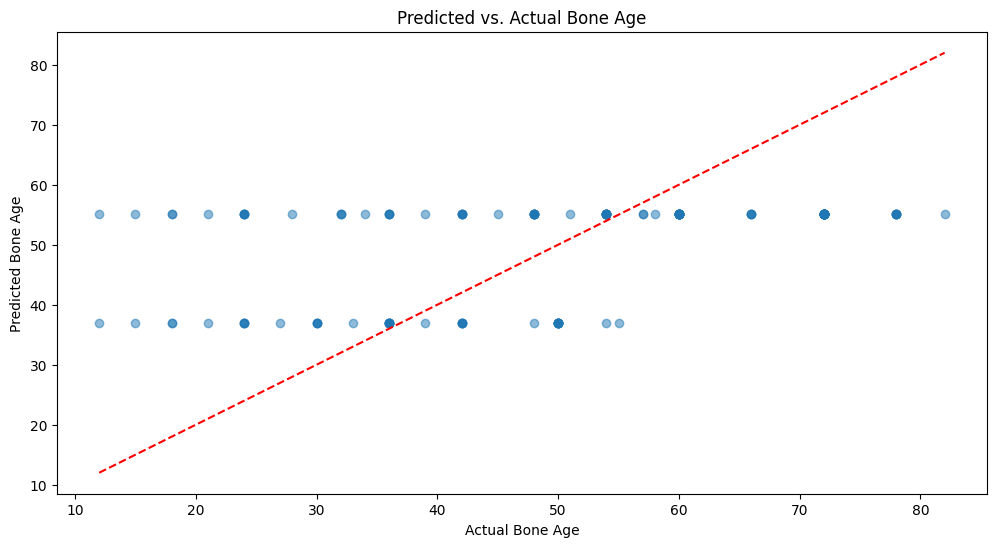

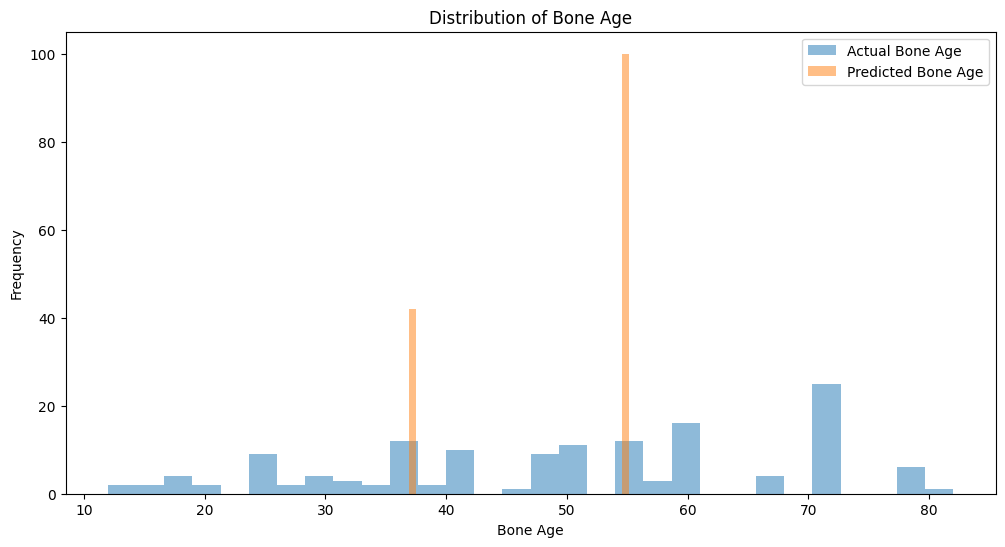

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the trained model
model_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/EfficientNet_bone_age_model.h5'
model = load_model(model_path)

# Load the CSV file
test_csv = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/test.csv'
test_df = pd.read_csv(test_csv)

# Directory containing resized images
resized_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Testing/resized'

# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Prepare test images and gender information
test_images = []
test_genders = []
test_boneages = []

for index, row in test_df.iterrows():
    img_path = os.path.join(resized_dir, str(row['id']) + '.png')  # Convert id to string
    test_images.append(load_and_preprocess_image(img_path))
    test_genders.append(1 if row['male'] else 0)  # Convert boolean to numeric (1 for male, 0 for female)
    test_boneages.append(row['boneage'])

# Stack images and convert lists to numpy arrays
test_images = np.vstack(test_images)
test_genders = np.array(test_genders).reshape(-1, 1)  # Ensure gender data is in the correct shape
test_boneages = np.array(test_boneages)

# Prepare the inputs for the model
test_images_with_gender = [test_images, test_genders]

# Predict bone age using the model
predicted_boneages = model.predict(test_images_with_gender)

# Calculate performance metrics
mae = np.mean(np.abs(predicted_boneages.flatten() - test_boneages))
mse = mean_squared_error(test_boneages, predicted_boneages)
rmse = np.sqrt(mse)
r2 = r2_score(test_boneages, predicted_boneages)

# Define accuracy threshold
accuracy_threshold = 2  # Adjust as needed (e.g., ±2 years)

# Calculate accuracy
accuracy = np.mean(np.abs(predicted_boneages.flatten() - test_boneages) <= accuracy_threshold) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R²): {r2:.2f}')
print(f'Accuracy (within ±{accuracy_threshold} years): {accuracy:.2f}%')

# Plot predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.scatter(test_boneages, predicted_boneages, alpha=0.5)
plt.plot([min(test_boneages), max(test_boneages)], [min(test_boneages), max(test_boneages)], 'r--')
plt.xlabel('Actual Bone Age')
plt.ylabel('Predicted Bone Age')
plt.title('Predicted vs. Actual Bone Age')
plt.show()

# Plot the distribution of predicted vs actual bone ages
plt.figure(figsize=(12, 6))
plt.hist(test_boneages, bins=30, alpha=0.5, label='Actual Bone Age')
plt.hist(predicted_boneages, bins=30, alpha=0.5, label='Predicted Bone Age')
plt.xlabel('Bone Age')
plt.ylabel('Frequency')
plt.title('Distribution of Bone Age')
plt.legend()
plt.show()


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 2784.9944 - mae: 49.8289

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 51s 1s/step - loss: 2784.9944 - mae: 49.8289 - val_loss: 2736.9363 - val_mae: 49.1402 - lr: 1.0000e-04
Epoch 2/50
36/36 [==============================] - 43s 1s/step - loss: 2757.4373 - mae: 49.7909 - val_loss: 2340.9580 - val_mae: 45.0720 - lr: 1.0000e-04
Epoch 3/50
36/36 [==============================] - 42s 1s/step - loss: 2725.8772 - mae: 49.6387 - val_loss: 2195.0007 - val_mae: 43.4791 - lr: 1.0000e-04
Epoch 4/50
36/36 [==============================] - 30s 841ms/step - loss: 2701.2183 - mae: 49.5824 - val_loss: 1905.0393 - val_mae: 40.1816 - lr: 1.0000e-04
Epoch 5/50
36/36 [==============================] - 37s 1s/step - loss: 2687.7976 - mae: 49.5441 - val_loss: 1519.8828 - val_mae: 35.2871 - lr: 1.0000e-04
Epoch 6/50
36/36 [==============================] - 40s 1s/step - loss: 2671.8950 - mae: 49.5025 - val_loss: 1387.1361 - val_mae: 33.5739 - lr: 1.0000e-04
Epoch 7/50
36/36 [==============================] - 15s 427ms/step - loss: 266

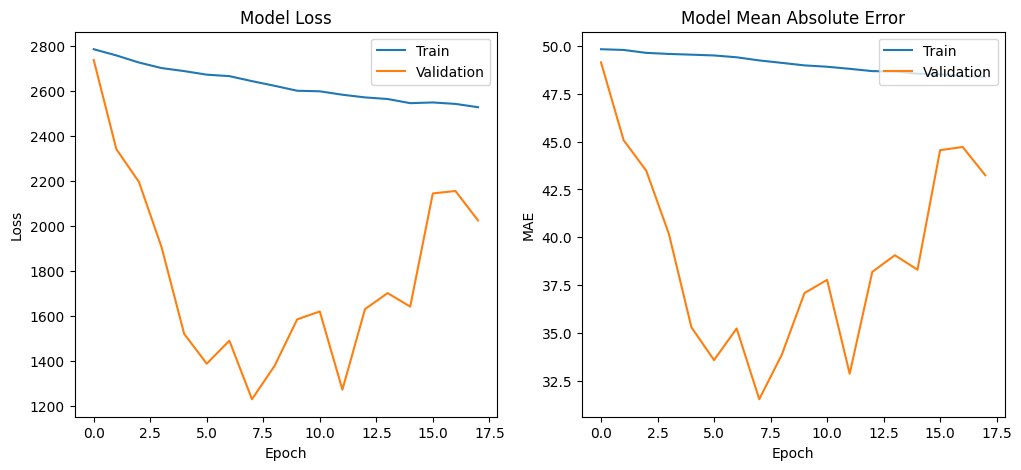

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Paths to data and CSV files
resized_training_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Training'
resized_val_dir = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Resized/Validation'
training_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/training.csv'
validation_csv_path = '/content/drive/MyDrive/FYP - Nexero/BAA model/Dataset/Training_Validation/Combined/validation.csv'

# Load the CSV data
train_df = pd.read_csv(training_csv_path)
val_df = pd.read_csv(validation_csv_path)

# Convert 'id' column to string
train_df['id'] = train_df['id'].astype(str)
val_df['id'] = val_df['id'].astype(str)

# Function to load images
def load_images_from_df(df, image_dir):
    images = []
    ages = []
    genders = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['id'] + '.png')
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            ages.append(row['boneage'])
            genders.append(row['male'])
    return np.array(images), np.array(ages), np.array(genders)

# Load training and validation images
X_train, y_train, genders_train = load_images_from_df(train_df, resized_training_dir)
X_val, y_val, genders_val = load_images_from_df(val_df, resized_val_dir)

# Image data generator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# ResNet50 base model
input_shape = X_train.shape[1:]
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers except the last few layers
for layer in resnet.layers[:-10]:
    layer.trainable = False

# Add custom layers
x = resnet.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add gender input
gender_input = Input(shape=(1,), name='gender_input')
gender_dense = Dense(32, activation='relu')(gender_input)
gender_dense = Dense(16, activation='relu')(gender_dense)

# Combine ResNet and gender inputs
combined = concatenate([x, gender_dense])
age_output = Dense(1, name='age_output')(combined)

model = Model(inputs=[resnet.input, gender_input], outputs=age_output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Model Checkpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP - Nexero/BAA model/ResNet_bone_age_model.h5',
                             monitor='val_loss', save_best_only=True, mode='min')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Create combined generator
def combined_generator(image_gen, gender_input):
    while True:
        batch_img, batch_age = image_gen.next()
        gender_data = gender_input[:len(batch_img)]
        yield [batch_img, gender_data], batch_age

# Train the model
history = model.fit(
    combined_generator(train_generator, genders_train),
    steps_per_epoch=len(train_generator),
    validation_data=([X_val / 255.0, genders_val], y_val),
    epochs=50,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Plotting the training history
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()
